<div class="alert alert-info">
    
➡️ Before you start, make sure that you are familiar with the **[study guide](https://liu-nlp.ai/text-mining/logistics/)**, in particular the rules around **cheating and plagiarism** (found in the course memo).

➡️ If you use code from external sources (e.g. StackOverflow, ChatGPT, ...) as part of your solutions, don't forget to add a reference to these source(s) (for example as a comment above your code).

➡️ Make sure you fill in all cells that say **`YOUR CODE HERE`** or **YOUR ANSWER HERE**.  You normally shouldn't need to modify any of the other cells.

</div>

# L4: Clustering and Topic Modelling

Text clustering groups documents in such a way that documents within a group are more &lsquo;similar&rsquo; to other documents in the cluster than to documents not in the cluster. The exact definition of what &lsquo;similar&rsquo; means in this context varies across applications and clustering algorithms.

In this lab you will experiment with both hard and soft clustering techniques. More specifically, in the first part you will be using the $k$-means algorithm, and in the second part you will be using a topic model based on the Latent Dirichlet Allocation (LDA).

In [1]:
# Define some helper functions that are used in this notebook

%matplotlib inline
from IPython.display import display, HTML

def success():
    display(HTML('<div class="alert alert-success"><strong>Checks have passed!</strong></div>'))

## Dataset 1: Hard clustering

The raw data for the hard clustering part of this lab is a collection of product reviews. We have preprocessed the data by tokenization and lowercasing.

In [2]:
import pandas as pd
import bz2

with bz2.open('reviews.json.bz2') as source:
    df = pd.read_json(source)

When you inspect the data frame, you can see that there are three labelled columns: `category` (the product category), `sentiment` (whether the product review was classified as &lsquo;positive&rsquo; or &lsquo;negative&rsquo; towards the product), and `text` (the space-separated text of the review).

In [3]:
pd.set_option('display.max_colwidth', None)
df.head()

,category,sentiment,text
0,music,neg,"i bought this album because i loved the title song . it 's such a great song , how bad can the rest of the album be , right ? well , the rest of the songs are just filler and are n't worth the money i paid for this . it 's either shameless bubblegum or oversentimentalized depressing tripe . kenny chesney is a popular artist and as a result he is in the cookie cutter category of the nashville music scene . he 's gotta pump out the albums so the record company can keep lining their pockets while the suckers out there keep buying this garbage to perpetuate more garbage coming out of that town . i 'll get down off my soapbox now . but country music really needs to get back to it 's roots and stop this pop nonsense . what country music really is and what it is considered to be by mainstream are two different things ."
1,music,neg,i was misled and thought i was buying the entire cd and it contains one song
2,books,neg,"i have introduced many of my ell , high school students to lois lowery and the depth of her characters . she is a brilliant writer and capable of inspiring fierce passion in her readers as they encounter shocking details of her utopian worlds . i was anxious to read this companion novel and had planned to share it with my class this january . although the series is written for 6th graders and older , this book 's simplicity , in its message , language and writing style will inspire no one . i am sadly disappointed"
3,books,pos,anything you purchase in the left behind series is an excellent read . these books are great and very close to the bible . i have the entire set . amazon is a great shopping site and they ship fast . i would recommend these to any christian wanting to know about what to expect during the return of christ ! they are fiction but still makes a good point
4,dvd,pos,"i loved these movies , and i cant wiat for the third one ! very funny , not suitable for chilren"


In [15]:
df['category'].unique()

array(['music', 'books', 'dvd', 'camera', 'health', 'software'],
      dtype=object)

## Problem 1: K-means clustering

Your first task is to cluster the product review data using a tf–idf vectorizer and $k$-means clustering.

### Task 1.1

Start by **performing tf–idf vectorization**. In connection with vectorization, you should also **filter out standard English stop words**. While you could use [spaCy](https://spacy.io/) for this task, here it suffices to use the word list implemented in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

After running the following cell:
- `vectorizer` should contain the vectorizer fitted on `df['text']`
- `reviews` should contain the vectorized `df['text']`

In [4]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load('en_core_web_md')    # Let’s use the "medium" (md) model this time
nlp.tokenizer = Tokenizer(nlp.vocab)  # ...but override the tokenizer

def filter_out_stop_words(x:str) -> str:
    doc = nlp(x)
    return " ".join([token.text for token in doc if not token.is_stop])

filter_out_stop_words("i bought this album because i loved the title song . it 's such a great song , how bad can the rest of the album be , right ? well , the rest of the songs are just filler and are n't worth the money i paid for this . it 's either shameless bubblegum or oversentimentalized depressing tripe . kenny chesney is a popular artist and as a result he is in the cookie cutter category of the nashville music scene . he 's gotta pump out the albums so the record company can keep lining their pockets while the suckers out there keep buying this garbage to perpetuate more garbage coming out of that town . i 'll get down off my soapbox now . but country music really needs to get back to it 's roots and stop this pop nonsense . what country music really is and what it is considered to be by mainstream are two different things .")

'bought album loved title song . great song , bad rest album , right ? , rest songs filler worth money paid . shameless bubblegum oversentimentalized depressing tripe . kenny chesney popular artist result cookie cutter category nashville music scene . gotta pump albums record company lining pockets suckers buying garbage perpetuate garbage coming town . soapbox . country music needs roots stop pop nonsense . country music considered mainstream different things .'

In [5]:
# YOUR CODE HERE
from sklearn.feature_extraction.text import TfidfVectorizer

df['filtered_text'] = df['text'].apply(filter_out_stop_words)

vectorizer = TfidfVectorizer()
reviews = vectorizer.fit_transform(df['filtered_text'])

### Task 1.2

Next, **write a function to cluster the vectorized data.**  For this, you can use scikit-learn’s [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, which has several parameters that you can tweak, the most important one being the _number of clusters_.  Your function should therefore take the number of clusters as an argument; you can leave all other parameters at their defaults. 

In [6]:
from sklearn.cluster import KMeans
import numpy as np
def fit_kmeans(data, n_clusters):
    """Fit a k-means classifier to some data.

    Arguments:
        data: The vectorized data to train the classifier on.
        n_clusters (int): The number of clusters.

    Returns:
        The trained k-means classifier.
    """
    # YOUR CODE HERE
    return KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(data)

To sanity-check your clustering, **create a bar plot** with the number of documents per cluster:

In [7]:
import matplotlib.pyplot as plt

def plot_cluster_size(kmeans):
    """Produce & display a bar plot with the number of documents per cluster.

    Arguments:
        kmeans: The trained k-means classifier.
    """
    # YOUR CODE HERE
    count = np.bincount(kmeans.labels_)
    
    plt.bar([f'cluster {n}' for n in range(0,len(count))], count)
    
    plt.xlabel('Category')
    plt.ylabel('Value')
    plt.title('plot_cluster_size')
    
    plt.show()

#### 🤞 Test your code

The following cell shows how your code should run.  The output of the cell should be the bar plot of the cluster sizes.  Note that sizes may vary considerably between clusters and among different random seeds, so there is no single “correct” output here!  Re-run the cell a couple of times to observe how the plot changes.

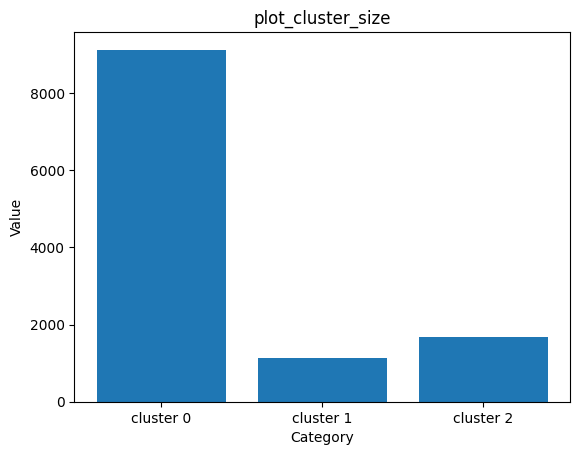

In [8]:
kmeans = fit_kmeans(reviews, 3)
plot_cluster_size(kmeans)

## Problem 2: Summarising clusters

Once you have a clustering, you can try to see whether it is meaningful. One useful technique in that context is to **generate a “summary”** for each cluster by extracting the $n$ highest-weighted terms from the centroid of each cluster. Your next task is to implement this approach.

In [9]:
import numpy as np

def compute_cluster_summaries(kmeans, vectorizer, top_n):
    """Compute the top_n highest-weighted terms from the centroid of each cluster.

    Arguments:
        kmeans: The trained k-means classifier.
        vectorizer: The fitted vectorizer; needed to obtain the actual terms
                    belonging to the items in the cluster.
        top_n: The number of terms to return for each cluster.

    Returns:
        A list of length k, where k is the number of clusters. Each item in the list
        should be a list of length `top_n` with the highest-weighted terms from that
        cluster.  Example:
          [["first", "foo", ...], ["second", "bar", ...], ["third", "baz", ...]]
    """
    # YOUR CODE HERE
    centers = kmeans.cluster_centers_
    feature_names = np.array(vectorizer.get_feature_names_out())

    summaries = []
    n_clusters = centers.shape[0]
    for i in range(n_clusters):
        centroid = centers[i]
        top_idx = np.flip(centroid.argsort())[:top_n]
        top_terms = feature_names[top_idx]
        summaries.append(top_terms.tolist())

    return summaries

### 🤞 Test your code

The following cell runs your code with `top_n=10` and prints the summaries:

In [10]:
summaries = compute_cluster_summaries(kmeans, vectorizer, 10)

for idx, terms in enumerate(summaries):
    print(f"Cluster {idx}: {', '.join(terms)}")

Cluster 0: book, product, movie, like, great, good, use, time, read, work
Cluster 1: camera, lens, pictures, canon, digital, use, battery, flash, quality, great
Cluster 2: album, cd, music, songs, quot, song, like, great, good, band


Once you have computed the cluster summaries, take a minute to reflect on their quality. Is it clear what the reviews in a given cluster are about? Do the cluster summaries contain any unexpected terms?

## Problem 3: Evaluate clustering performance

In some scenarios, you may have gold-standard class labels available for at least a subset of your documents.  In our case, we could use the gold-standard categories (from the `category` column) as class labels.  This means we’re making the assumption that a “good” clustering should put texts into the same cluster _if and only if_ they belong to the same category.

If we have such class labels, we can compute a variety of performance measures to see how well our $k$-means clustering resembles the given class labels.  Here, we will consider three of these measures: the **Rand index (RI)**; the **adjusted Rand index (RI)** which has been corrected for chance; and the **V-measure**.  For all of them (and more), we can make use of [implementations by scikit-learn](https://scikit-learn.org/1.5/modules/clustering.html#clustering-performance-evaluation).

Your task is to **compare the performance** of different $k$-means clusterings with $k = 1, \ldots, 10$ clusters.  As your evaluation data, use the _first 1000 documents_ from the original data set along with their gold-standard categories (from the `category` column).

**Visualise your results as a line plot**, where

- the $x$-axis corresponds to $k$
- the $y$-axis corresponds to the score of the evaluation measure
- each evaluation measure (RI, ARI, V) is shown by a differently-colored and/or -styled line in the plot

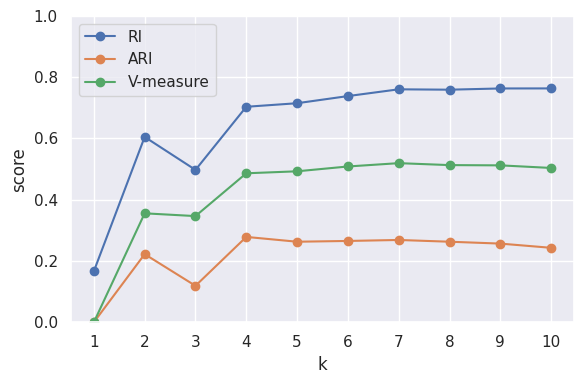

In [13]:
from sklearn.metrics import rand_score, adjusted_rand_score, v_measure_score
import seaborn as sns

sns.set()


# YOUR CODE HERE
def calculate_RI(kmeans: KMeans):
    ri = rand_score(df['category'][:1000], kmeans.labels_[:1000])
    ari = adjusted_rand_score(df['category'][:1000], kmeans.labels_[:1000])
    vm = v_measure_score(df['category'][:1000], kmeans.labels_[:1000])
    return (ri, ari, vm)
    
ms = []

ks = list(range(1, 11))   # k = 1..10
for k in ks:
    kmeans = fit_kmeans(reviews, k)
    ms.append(calculate_RI(kmeans))


ms = np.array(ms)

plt.figure(figsize=(6,4))
plt.plot(ks, ms[:,0], marker='o', label='RI')
plt.plot(ks, ms[:,1], marker='o', label='ARI')
plt.plot(ks, ms[:,2], marker='o', label='V-measure')

plt.xlabel('k')
plt.ylabel('score')
plt.xticks(ks)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Remember that you may get different clusters each time you run the $k$-means algorithm, so re-run your solution above a few times to see how the results change.  Take a moment to think how you would interpret these results; you will need this for the reflection.

## Dataset 2: Topic modelling

The data set for the topic modelling part of this lab is the collection of all [State of the Union](https://en.wikipedia.org/wiki/State_of_the_Union) addresses from the years 1975–2000. These speeches come as a single text file with one sentence per line. The following code cell prints the first 5 lines from the data file:

In [14]:
from itertools import islice

with open('sotu_1975_2000.txt') as source:
    # Print the first 5 lines only
    for line in islice(source, 5):
        print(line.rstrip())

mr speaker mr vice president members of the 94th congress and distinguished guests
twenty six years ago a freshman congressman a young fellow with lots of idealism who was out to change the world stood before sam rayburn in the well of the house and solemnly swore to the same oath that all of you took yesterday an unforgettable experience and i congratulate you all
two days later that same freshman stood at the back of this great chamber over there someplace as president truman all charged up by his single handed election victory reported as the constitution requires on the state of the union
when the bipartisan applause stopped president truman said i am happy to report to this 81st congress that the state of the union is good our nation is better able than ever before to meet the needs of the american people and to give them their fair chance in the pursuit of happiness it is foremost among the nations of the world in the search for peace
today that freshman member from michigan stan

Take a few minutes to think about what topics you would expect in this data set.

## Problem 4: Train a topic model

In this problem, we will train an LDA model on the State of the Union&nbsp;(SOTU) dataset. For this, we will be using [spaCy](https://spacy.io/) and the [gensim](https://radimrehurek.com/gensim/) topic modelling library.


### Task 4.1: Preparing the data

Start by **preprocessing the data** using spaCy as follows:

- Filter out stop words, non-alphabetic tokens, and tokens less than 3 characters in length.
- Store the documents as a nested list where the first level of nesting corresponds to the sentences and the second level corresponds to the tokens in each sentence.

In [17]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [21]:
def load_and_preprocess_documents(filename="sotu_1975_2000.txt"):
    """Load and preprocess all documents in the given file.

    The preprocessing must filter out stop words, non-alphabetic tokens,
    and tokens less than 3 characters in length.

    Returns:
        A list of length n, where n is the number of documents.
        Each item in the list should be a list of tokens in the given
        document, after preprocessing.
    """
    # YOUR CODE HERE
    ret = []
    with open('sotu_1975_2000.txt') as source:        
        for sentence in source:
            doc = nlp(sentence.rstrip())
            ret.append([token.text for token in doc if (not token.is_stop) and token.is_alpha and len(token.text) >= 3])
    return ret

#### 🤞 Test your code

Test your preprocessing by running the following cell. It will output the tokens (after preprocessing) for an example document and compare them against the expected output.

In [22]:
documents = load_and_preprocess_documents()

print(f"Document 42 after preprocessing: {' '.join(documents[42])}")
assert " ".join(documents[42]) == "reduce oil imports million barrels day end year million barrels day end"
success()

Document 42 after preprocessing: reduce oil imports million barrels day end year million barrels day end


### Task 4.2: Training LDA

Now that we have the list of documents, we can use gensim to train an LDA model on them.  Gensim works a bit differently from scikit-learn and has its own interfaces, so you should skim the section [“Pre-process and vectorize the documents”](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents) of the documentation to learn how to create the dictionary and the vectorized corpus representation required by gensim.

Based on this, **write code to train an [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html)** for $k=10$ topics, and using default values for all other parameters.

In [23]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

def train_lda_model(documents, num_topics, passes=1):
    """Create and train an LDA model.

    Arguments:
        documents: The preprocessed documents, as produced in Task 4.1.
        num_topics: The number of topics to generate.
        passes: The number of training passes. Defaults to 1; you will need
                this later for Task 5.

    Returns:
        The trained LDA model.
    """
    # YOUR CODE HERE

    dictionary = Dictionary(documents)

    corpus = [dictionary.doc2bow(doc) for doc in documents]

    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=passes,
        iterations=100,
    )
    return lda

#### 🤞 Test your code

Run the following cell to test your code and print the topics:

In [26]:
model = train_lda_model(documents, 10)
model.print_topics()

[(0,
  '0.012*"welfare" + 0.009*"people" + 0.008*"work" + 0.008*"america" + 0.008*"health" + 0.007*"care" + 0.007*"children" + 0.007*"thank" + 0.006*"help" + 0.006*"americans"'),
 (1,
  '0.010*"people" + 0.007*"america" + 0.007*"new" + 0.007*"years" + 0.007*"government" + 0.007*"american" + 0.006*"nuclear" + 0.005*"year" + 0.005*"economy" + 0.005*"community"'),
 (2,
  '0.025*"america" + 0.011*"world" + 0.009*"parents" + 0.008*"schools" + 0.008*"child" + 0.007*"challenge" + 0.007*"new" + 0.006*"peace" + 0.006*"education" + 0.006*"help"'),
 (3,
  '0.010*"america" + 0.009*"world" + 0.008*"children" + 0.007*"american" + 0.007*"new" + 0.006*"let" + 0.006*"work" + 0.006*"god" + 0.006*"people" + 0.006*"century"'),
 (4,
  '0.011*"people" + 0.011*"new" + 0.010*"government" + 0.010*"tax" + 0.008*"year" + 0.007*"help" + 0.007*"college" + 0.007*"care" + 0.006*"congress" + 0.006*"time"'),
 (5,
  '0.011*"world" + 0.010*"year" + 0.008*"america" + 0.008*"congress" + 0.007*"new" + 0.007*"people" + 0.00

Inspect the topics. Can you &lsquo;label&rsquo; each topic with a short description of what it is about? Do the topics match your expectations?

## Problem 5: Monitor a topic model for convergence

When learning an LDA model, it is important to make sure that the training algorithm has converged to a stable posterior distribution. One way to do so is to plot, after each training epochs (or &lsquo;pass&rsquo;, in gensim parlance) the log likelihood of the training data under the posterior. Your last task in this lab is to create such a plot and, based on this, to suggest an appropriate number of epochs.

To collect information about the posterior likelihood after each pass, we need to enable the logging facilities of gensim. Once this is done, gensim will add various diagnostics to a log file `gensim.log`.

In [27]:
import logging

logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

def clear_logfile():
    # To empty the log file
    with open("gensim.log", "w"):
        pass

The following function will parse the generated logfile and return the list of log likelihoods.

In [28]:
import re

def parse_logfile():
    """Parse gensim.log to extract the log-likelihood scores.

    Returns:
        A list of log-likelihood scores.
    """
    matcher = re.compile(r'(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

Here's an example how to run it — note that we call `clear_logfile()` to empty the logfile before training the model. If your code from Problem&nbsp;4 was correct, the result should be a list with a single log-likehood score, since we are doing a single training pass:

In [29]:
clear_logfile()
model = train_lda_model(documents, 10, passes=1)
likelihoods = parse_logfile()
print(likelihoods)

[-9.645]


### Task 5.1: Plotting log-likelihoods

Your task now is to **re-train your LDA model for 50&nbsp;passes**, retrieve the list of log likelihoods, and **create a plot** from this data.

In [30]:
# YOUR CODE HERE
clear_logfile()
model = train_lda_model(documents, 10, passes=50)
likelihoods = parse_logfile()
print(likelihoods)

[-9.645, -9.021, -8.683, -8.383, -8.241, -8.182, -8.149, -8.127, -8.11, -8.097, -8.087, -8.078, -8.07, -8.063, -8.058, -8.052, -8.048, -8.044, -8.04, -8.037, -8.034, -8.031, -8.029, -8.026, -8.024, -8.022, -8.02, -8.019, -8.017, -8.016, -8.014, -8.013, -8.012, -8.01, -8.009, -8.008, -8.007, -8.006, -8.006, -8.005, -8.004, -8.003, -8.003, -8.002, -8.001, -8.001, -8.0, -7.999, -7.999, -7.998]


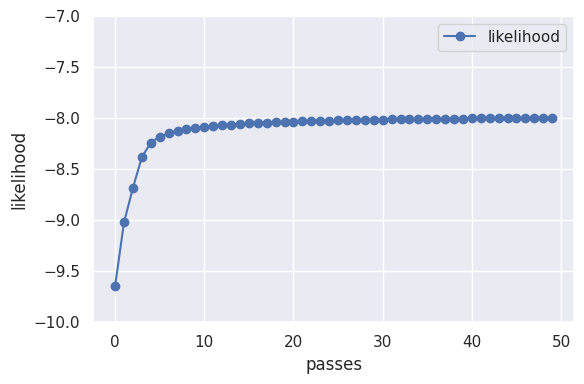

In [35]:
plt.figure(figsize=(6,4))

xs = range(0,50)
plt.plot(xs, likelihoods, marker='o', label='likelihood')

plt.xlabel('passes')
plt.ylabel('likelihood')
plt.ylim(-10, -7)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Task 5.2: Interpreting log-likelihoods

How do you interpret the plot you produced in Task 5.1? Based on the plot, what would be a reasonable choice for the number of passes? **Retrain your LDA model with that number** and re-inspect the topics it finds.

In [36]:
# YOUR CODE HERE
model = train_lda_model(documents, 10, 15)
model.print_topics()

[(0,
  '0.014*"welfare" + 0.013*"health" + 0.012*"care" + 0.011*"people" + 0.009*"work" + 0.009*"thank" + 0.009*"children" + 0.008*"year" + 0.008*"like" + 0.007*"insurance"'),
 (1,
  '0.006*"government" + 0.006*"development" + 0.006*"nation" + 0.006*"women" + 0.006*"years" + 0.006*"national" + 0.005*"economic" + 0.005*"system" + 0.005*"nuclear" + 0.005*"states"'),
 (2,
  '0.035*"america" + 0.023*"world" + 0.015*"new" + 0.011*"american" + 0.011*"century" + 0.011*"economy" + 0.010*"nation" + 0.010*"trade" + 0.010*"future" + 0.008*"union"'),
 (3,
  '0.011*"god" + 0.009*"america" + 0.007*"world" + 0.007*"bless" + 0.006*"food" + 0.006*"let" + 0.006*"thank" + 0.005*"new" + 0.005*"clean" + 0.005*"technologies"'),
 (4,
  '0.018*"tax" + 0.015*"federal" + 0.014*"government" + 0.012*"budget" + 0.012*"year" + 0.010*"programs" + 0.010*"billion" + 0.009*"new" + 0.009*"congress" + 0.007*"help"'),
 (5,
  '0.017*"nuclear" + 0.015*"world" + 0.013*"weapons" + 0.011*"war" + 0.007*"congress" + 0.007*"year"

## Individual reflection

<div class="alert alert-info">
    <strong>After you have solved the lab,</strong> write a <em>brief</em> reflection (max. one A4 page) on the question(s) below.  Remember:
    <ul>
        <li>You are encouraged to discuss this part with your lab partner, but you should each write up your reflection <strong>individually</strong>.</li>
        <li><strong>Do not put your answers in the notebook</strong>; upload them in the separate submission opportunity for the reflections on Lisam.</li>
    </ul>
</div>

1. In Problem&nbsp;3, you performed an evaluation of $k$-means clustering with different values for $k$.  How do you interpret the results?  What would you expect to be a “good” number of clusters for this dataset?  What do the evaluation measures suggest would be a “good” number of clusters?
2. How did you choose the number of LDA passes in Task&nbsp;5.2?  Do you consider the topic clusters you got in Task&nbsp;5.2 to be “better” than the ones from Task&nbsp;4.2?  Base your reasoning on one or more concrete examples from the LDA output.

**Congratulations on finishing this lab! 👍**

<div class="alert alert-info">
    
➡️ Before you submit, **make sure the notebook can be run from start to finish** without errors.  For this, _restart the kernel_ and _run all cells_ from top to bottom. In Jupyter Notebook version 7 or higher, you can do this via "Run$\rightarrow$Restart Kernel and Run All Cells..." in the menu (or the "⏩" button in the toolbar).

</div>